## 2022년 제10회 산업통상자원부 공공데이터 활용 비즈니스 아이디어 공모전
### - 빅데이터 분석 부문

#### : 딥러닝을 통한 한국 수출금액 예측모델 구축
---
#### 김서진, 이준서





In [ ]:
### 필요한 패키지 로드
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

### 1. Data Preprocessing

#### 1-1. Data loading

In [ ]:
### 사전에 엑셀에서 csv로 raw data를 저장한 뒤 csv 로드
from google.colab import files
file1 = files.upload()

data = pd.read_csv("data2.csv")
data.head()

Saving data2.csv to data2.csv


,기간,한국 수출금액,한국의대중국수출,한국의대미국수출,한국의대베트남수출,한국의대홍콩수출,한국의대일본수출
0,2000.01,12162424632,1235215271,2609787984,109742698,782348732,1551722070
1,2000.02,12676042304,1273117309,2554309883,112395157,823990122,1518844843
2,2000.03,14429703086,1437377223,2946820669,150134562,911648256,1783564618
3,2000.04,13522040017,1366876604,2698029849,169146208,863243219,1582707525
4,2000.05,14636754971,1663240667,3167181403,169411680,887081090,1671039709


- 모델 구축을 위한 추가 변수로 국내총생산 및 경제성장률을 선택하였다. 해당 데이터는 한국은행[국민소득]에서 제공한 데이터를 가공해 활용하였다.

In [ ]:
file2 = files.upload()
GDP = pd.read_csv("/content/국내총생산 및 경제성장률.csv")
GDP.head()

Saving 국내총생산 및 경제성장률.csv to 국내총생산 및 경제성장률 (1).csv


,통계표명:,국내총생산 및 경제성장률,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 79,Unnamed: 80,Unnamed: 81,Unnamed: 82,Unnamed: 83,Unnamed: 84,Unnamed: 85,Unnamed: 86,Unnamed: 87,Unnamed: 88
0,단위:,"십억원, 전년동기비 %",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,2000\r\n1/4,2000\r\n2/4,2000\r\n3/4,2000\r\n4/4,2001\r\n1/4,2001\r\n2/4,2001\r\n3/4,2001\r\n4/4,2002\r\n1/4,...,2019\r\n3/4,2019\r\n4/4,2020\r\n1/4,2020\r\n2/4,2020\r\n3/4,2020\r\n4/4,2021\r\n1/4,2021\r\n2/4,2021\r\n3/4,2021\r\n4/4
2,국내총생산(명목GDP),"152,404.4","160,404.4","166,224.9","172,397.6","165,662.3","176,302.9","179,613.6","185,242.5","182,815.1",...,"487,177.0","497,064.8","458,202.4","472,328.1","491,181.5","492,100.1","501,248.1","511,233.1","518,021.3","526,257.6"
3,경제성장률(실질GDP성장률),12.7,9.1,9.1,5.9,5.1,4.9,3.5,5.9,7.2,...,2.0,2.3,-1.3,-3.2,2.2,1.1,1.7,0.8,0.3,1.2
4,출처:,한국은행「국민소득」,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


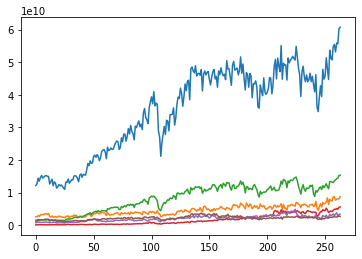

In [ ]:
#check data trend
plt.plot(data['한국 수출금액'])
plt.plot(data['한국의대미국수출'])
plt.plot(data['한국의대중국수출'])
plt.plot(data['한국의대베트남수출'])
plt.plot(data['한국의대홍콩수출'])
plt.plot(data['한국의대일본수출'])
plt.show()

#### 1-2. GDP data preprocessing

In [ ]:
### GDP data preprocessing
GDP = GDP.T
GDP = GDP[[2,3]]
GDP.dtypes
GDP.reset_index(inplace=True, drop=True)
GDP.columns = ['GDP','Growth_rate']
GDP.drop(GDP.index[0], inplace=True)
GDP['GDP']=GDP['GDP'].str.replace(",","")
GDP = GDP.apply(pd.to_numeric)
GDP.dtypes

GDP            float64
Growth_rate    float64
dtype: object

In [ ]:
GDP.head()

,GDP,Growth_rate
1,152404.4,12.7
2,160404.4,9.1
3,166224.9,9.1
4,172397.6,5.9
5,165662.3,5.1


In [ ]:
### 분기 데이터인 GDP, 경제성장률 활용을 위해 동 분기는 동일 데이터로 설정
time = data['기간']
rep_GDP = []
rep_GR = []
for _ in range(1, len(GDP)+1):
  for i in range(3):
    rep_GDP.append(GDP['GDP'][_])
    rep_GR.append(GDP['Growth_rate'][_])
print(len(rep_GDP), len(rep_GR))

264 264


In [ ]:
### 원 데이터에 새로운 변수로 추가
data['GDP'] = rep_GDP
data['Growth_rate'] = rep_GR
data.head()

,기간,한국 수출금액,한국의대중국수출,한국의대미국수출,한국의대베트남수출,한국의대홍콩수출,한국의대일본수출,GDP,Growth_rate
0,2000.01,12162424632,1235215271,2609787984,109742698,782348732,1551722070,152404.4,12.7
1,2000.02,12676042304,1273117309,2554309883,112395157,823990122,1518844843,152404.4,12.7
2,2000.03,14429703086,1437377223,2946820669,150134562,911648256,1783564618,152404.4,12.7
3,2000.04,13522040017,1366876604,2698029849,169146208,863243219,1582707525,160404.4,9.1
4,2000.05,14636754971,1663240667,3167181403,169411680,887081090,1671039709,160404.4,9.1


In [ ]:
data.to_csv("data_processed.csv")

### Variable Setting

In [ ]:
iv = ['한국의대중국수출','한국의대미국수출','한국의대베트남수출','한국의대홍콩수출','한국의대일본수출']
iv2 = ['한국의대중국수출','한국의대미국수출','한국의대베트남수출','한국의대홍콩수출','한국의대일본수출','GDP','Growth_rate']
iv3 = ['한국 수출금액','한국의대중국수출','한국의대미국수출','한국의대베트남수출','한국의대홍콩수출','한국의대일본수출','GDP','Growth_rate']


### 2. Basic Regression model

In [ ]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor()

#### 2-1. Regression with MinMaxScaler

In [ ]:
sc1 = MinMaxScaler()
data_scaled = sc1.fit_transform(data)
X = data[iv]
X = sc1.fit_transform(X)
y = data['한국 수출금액']


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.3, random_state = 0)


In [ ]:
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
RMSE1 = mean_squared_error(y_test, y_pred)**0.5
print(RMSE1)

1722544982.8757906


#### 2-2. Regression with Standard Scaling

In [ ]:
from sklearn.preprocessing import StandardScaler
sc2 = StandardScaler()
X_scaled = sc2.fit_transform(X)

In [ ]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_scaled, y,
                                                    test_size = 0.3, random_state = 0)


In [ ]:
lr2 = LinearRegression()
lr2.fit(X_train2,y_train2)
y_pred2 = lr2.predict(X_test2)
RMSE2 = mean_squared_error(y_test2, y_pred2)**0.5
print(RMSE2)

1722544982.8757918


In [ ]:
rfr.fit(X_train, y_train)
y_pred = rfr.predict(X_test)
RMSE_rfr = mean_squared_error(y_test, y_pred)**0.5
print(RMSE_rfr)

1766606950.7406597


### 3. RNN

#### 3-1. Data generation for RNN

In [ ]:
import torch
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'{device} is available')

cuda:0 is available


In [ ]:
sc3 = MinMaxScaler()
data2 = data #copy data
data[iv3] = sc3.fit_transform(data[iv3])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264 entries, 0 to 263
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   기간           264 non-null    float64
 1   한국 수출금액      264 non-null    float64
 2   한국의대중국수출     264 non-null    float64
 3   한국의대미국수출     264 non-null    float64
 4   한국의대베트남수출    264 non-null    float64
 5   한국의대홍콩수출     264 non-null    float64
 6   한국의대일본수출     264 non-null    float64
 7   GDP          264 non-null    float64
 8   Growth_rate  264 non-null    float64
dtypes: float64(9)
memory usage: 18.7 KB


In [ ]:
data.head()

,기간,한국 수출금액,한국의대중국수출,한국의대미국수출,한국의대베트남수출,한국의대홍콩수출,한국의대일본수출,GDP,Growth_rate
0,2000.01,0.022920,0.000000,0.052474,0.002700,0.029286,0.186491,0.000000,1.000000
1,2000.02,0.033252,0.002687,0.043965,0.003181,0.039095,0.174155,0.000000,1.000000
2,2000.03,0.068529,0.014330,0.104167,0.010015,0.059744,0.273487,0.000000,1.000000
3,2000.04,0.050271,0.009333,0.066008,0.013458,0.048341,0.198118,0.021399,0.773585
4,2000.05,0.072694,0.030341,0.137965,0.013506,0.053956,0.231263,0.021399,0.773585


In [ ]:
X = data[iv2].values
y = data['한국 수출금액'].values

In [ ]:
### define data generating function
def seq_data(x, y, seq):
  
  x_seq = []
  y_seq = []
  for i in range(len(x) - seq):
    x_seq.append(x[i: i+seq])
    y_seq.append(y[i+seq])
  # tensor, GPU available
  return torch.FloatTensor(x_seq).to(device), torch.FloatTensor(y_seq).to(device).view([-1, 1])

In [ ]:
X_seq, y_seq = seq_data(X, y, 6)
split = 210

X_train = X_seq[:split]
y_train = y_seq[:split]
X_test = X_seq[split:]
y_test = y_seq[split:]
print(X_train.size(), y_train.size())
print(X_test.size(), y_test.size())

torch.Size([210, 6, 7]) torch.Size([210, 1])
torch.Size([48, 6, 7]) torch.Size([48, 1])


In [ ]:
train = torch.utils.data.TensorDataset(X_train, y_train)
test = torch.utils.data.TensorDataset(X_test, y_test)

batch_size = 20
train_loader = torch.utils.data.DataLoader(dataset=train, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test, batch_size=batch_size, shuffle=False)

#### 3-2. Vanilla RNN

In [ ]:
input_size = X_seq.size(2)
num_layers = 2
hidden_size = 10
seq = 6

In [ ]:
class VanillaRNN(torch.nn.Module):

  def __init__(self, input_size, hidden_size, sequence_length, num_layers, device):
    super(VanillaRNN, self).__init__()
    self.device = device
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.rnn = torch.nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
    self.fc = torch.nn.Sequential(torch.nn.Linear(hidden_size * sequence_length, 1), torch.nn.Sigmoid())

  def forward(self, x):
    h0 = torch.zeros(self.num_layers, x.size()[0], self.hidden_size).to(self.device) # 초기 hidden state 설정하기.
    out, _ = self.rnn(x, h0) # out: RNN의 마지막 레이어로부터 나온 output feature 를 반환한다. hn: hidden state를 반환한다.
    out = out.reshape(out.shape[0], -1) # many to many 전략
    out = self.fc(out)
    return out


In [ ]:
model_vanilla = VanillaRNN(input_size=input_size,
                   hidden_size=hidden_size,
                   sequence_length=seq,
                   num_layers=num_layers,
                   device=device).to(device)

In [ ]:
criterion = torch.nn.MSELoss()

lr = 1e-3
num_epochs = 1000
optimizer = torch.optim.Adam(model_vanilla.parameters(), lr=lr)

#### 3-3. Model Training

In [ ]:
loss_graph = [] 
n = len(train_loader)

for epoch in range(num_epochs):
  running_loss = 0.0

  for data in train_loader:

    seq, target = data 
    out = model_vanilla(seq)  
    loss = criterion(out, target) 

    optimizer.zero_grad() 
    loss.backward() 
    optimizer.step() 
    running_loss += loss.item() 

  loss_graph.append(running_loss / n) 
  print('[epoch: %d] loss: %f'%(epoch, running_loss/n))


[epoch: 0] loss: 0.066962
[epoch: 1] loss: 0.060375
[epoch: 2] loss: 0.057246
[epoch: 3] loss: 0.054033
[epoch: 4] loss: 0.050214
[epoch: 5] loss: 0.045522
[epoch: 6] loss: 0.039758
[epoch: 7] loss: 0.032654
[epoch: 8] loss: 0.024042
[epoch: 9] loss: 0.014791
[epoch: 10] loss: 0.007601
[epoch: 11] loss: 0.004453
[epoch: 12] loss: 0.003616
[epoch: 13] loss: 0.003180
[epoch: 14] loss: 0.002888
[epoch: 15] loss: 0.002724
[epoch: 16] loss: 0.002594
[epoch: 17] loss: 0.002459
[epoch: 18] loss: 0.002313
[epoch: 19] loss: 0.002165
[epoch: 20] loss: 0.002022
[epoch: 21] loss: 0.001888
[epoch: 22] loss: 0.001761
[epoch: 23] loss: 0.001642
[epoch: 24] loss: 0.001529
[epoch: 25] loss: 0.001423
[epoch: 26] loss: 0.001323
[epoch: 27] loss: 0.001230
[epoch: 28] loss: 0.001144
[epoch: 29] loss: 0.001064
[epoch: 30] loss: 0.000991
[epoch: 31] loss: 0.000924
[epoch: 32] loss: 0.000862
[epoch: 33] loss: 0.000807
[epoch: 34] loss: 0.000756
[epoch: 35] loss: 0.000710
[epoch: 36] loss: 0.000668
[epoch: 37]

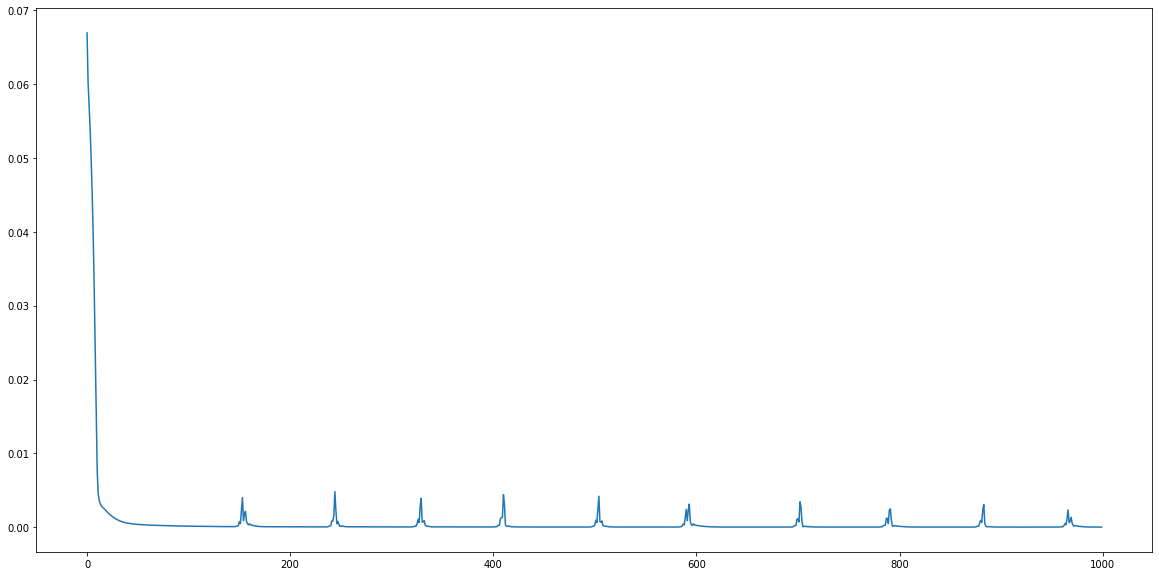

In [ ]:
### plot train loss
plt.figure(figsize=(20,10))
plt.plot(loss_graph)
plt.show()

In [ ]:
### plot real data and predicted data
def plotting(train_loader, test_loader, actual):
  with torch.no_grad():
    train_pred = []
    test_pred = []

    for data in train_loader:
      seq, target = data
      out = model_vanilla(seq)
      train_pred += out.cpu().numpy().tolist()

    for data in test_loader:
      seq, target = data
      out = model_vanilla(seq)
      test_pred += out.cpu().numpy().tolist()
      
  total = train_pred + test_pred
  plt.figure(figsize=(20,10))
  plt.plot(np.ones(100)*len(train_pred), np.linspace(0,1,100), '--', linewidth=0.6)
  plt.plot(actual, '--')
  plt.plot(total, 'b', linewidth=0.6)

  plt.legend(['train boundary', 'actual', 'prediction'])
  plt.show()
  return test_pred

In [ ]:
train_predict = model_vanilla(X_seq)
data_pred = train_predict.cpu()
data_pred = data_pred.data.numpy()
Y_plot = y_seq.cpu()
Y_plot = Y_plot.data.numpy()
data_pred = np.array(data_pred).flatten().tolist()
data_pred = [0,0,0,0,0,0]+data_pred

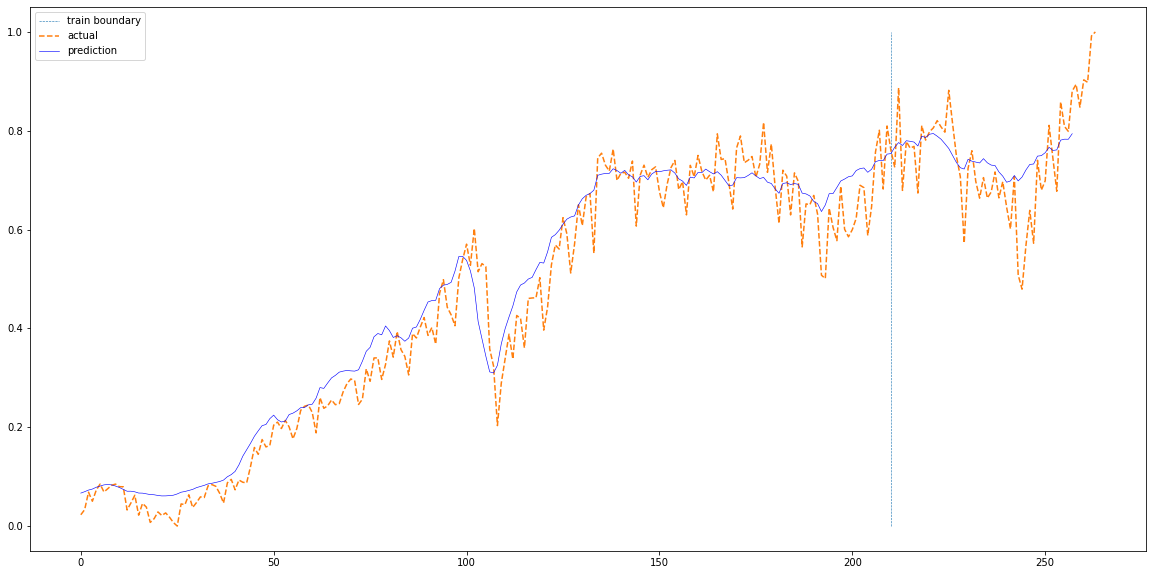

In [ ]:
scaler2 = MinMaxScaler()
data4 = scaler2.fit_transform(data3)
actual = data4[:,1]
test2 = plotting(train_loader, test_loader, actual)

In [ ]:
data3 = pd.read_csv("/content/data2.csv")

In [ ]:
data2['한국 수출금액'] = data_pred
res1 = sc3.inverse_transform(data2[iv3])
res1 = pd.DataFrame(res1)
y_pred2 = res1[0][210:].values.tolist()

In [ ]:
y_plt = data3['한국 수출금액'][210:].values
y_plt

array([48830439652, 47105568514, 55115239696, 44791238727, 49707196884,
       49040139428, 49221290908, 44523529594, 51309931550, 49850235277,
       50687749864, 51079375327, 51810254527, 51180449254, 50650208140,
       54860309595, 51479529532, 48206793082, 46168934249, 39481803311,
       47003206185, 48781156049, 45703948228, 44008404018, 46078221134,
       44020065156, 44629052707, 46648756033, 44040721772, 45668341127,
       43103060857, 40911818805, 46167203855, 36270182837, 34854511400,
       39214070630, 42785144050, 39469230580, 47819947522, 44818534427,
       45751883232, 51332449396, 48006973697, 44706906918, 53690914321,
       51225991397, 50725161248, 54778904949, 55461518159, 53165103786,
       55913862375, 55660372637, 60330542263, 60734116670])

In [ ]:
RMSE3 = mean_squared_error(y_plt, y_pred2)**0.5
print(RMSE3)

4726445072.171433


In [ ]:
4726445072.171433>1722544982.8757906

True

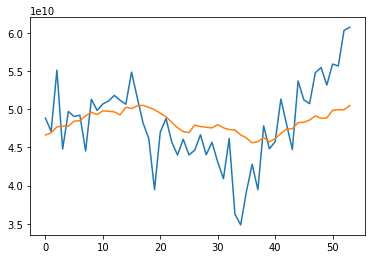

In [ ]:
plt.plot(y_plt)
plt.plot(y_pred2)
plt.show()

#### 3-4. Add Real data

In [ ]:
## test data
X_real = pd.DataFrame([[13369977988, 13039031759, 15645484899, 12951797773, 13409688055],
                      [8568228734, 7741505428, 9640275169, 9606880252, 9620008976],
                      [5305950119, 5235905235, 6137313470, 540334596, 4944474365], 
                      [2497541821, 2413632340, 2847000141, 2303324331, 2639336570],
                      [2619529430, 2480632295, 2778454362, 2637731043, 2831079782],], 
                      columns = ['한국의대중국수출','한국의대미국수출','한국의대베트남수출','한국의대홍콩수출','한국의대일본수출'])

In [ ]:
y_real = pd.DataFrame([55457577000, 54008302000, 63780433000, 57858183000, 61509507000], columns = ['총 수출'])

In [ ]:
data_real = pd.concat([y_real, X_real], axis=1, ignore_index=True)
id = [264, 265, 267, 268, 269]
data_real = data_real.set_index(keys = [id], inplace=False)
data_real.columns = ['한국 수출금액','한국의대중국수출','한국의대미국수출','한국의대베트남수출','한국의대홍콩수출','한국의대일본수출']
data_real

,한국 수출금액,한국의대중국수출,한국의대미국수출,한국의대베트남수출,한국의대홍콩수출,한국의대일본수출
264,55457577000,13369977988,13039031759,15645484899,12951797773,13409688055
265,54008302000,8568228734,7741505428,9640275169,9606880252,9620008976
267,63780433000,5305950119,5235905235,6137313470,540334596,4944474365
268,57858183000,2497541821,2413632340,2847000141,2303324331,2639336570
269,61509507000,2619529430,2480632295,2778454362,2637731043,2831079782


In [ ]:
file3 = files.upload()
data_processed = pd.read_csv("/content/data_processed.csv")
data_processed

Saving data_processed.csv to data_processed.csv


,기간,한국 수출금액,한국의대중국수출,한국의대미국수출,한국의대베트남수출,한국의대홍콩수출,한국의대일본수출,GDP,Growth_rate
0,2000.01,12162424632,1235215271,2609787984,109742698,782348732,1551722070,152404.4,12.7
1,2000.02,12676042304,1273117309,2554309883,112395157,823990122,1518844843,152404.4,12.7
2,2000.03,14429703086,1437377223,2946820669,150134562,911648256,1783564618,152404.4,12.7
3,2000.04,13522040017,1366876604,2698029849,169146208,863243219,1582707525,160404.4,9.1
4,2000.05,14636754971,1663240667,3167181403,169411680,887081090,1671039709,160404.4,9.1
...,...,...,...,...,...,...,...,...,...
259,2021.08,53165103786,13881327880,7704223847,4850337611,3415828590,2522980082,518021.3,0.3
260,2021.09,55913862375,14291980345,7983934107,5101701490,3852088155,2541017857,518021.3,0.3
261,2021.10,55660372637,14415867215,8066782602,4904971459,2739662629,2614683864,526257.6,1.2
262,2021.11,60330542263,15272549044,8133640339,5478296945,3232583381,2813250497,526257.6,1.2


In [ ]:
data_real['기간'] = [2022.01, 2022.02, 2022.03, 2022.04, 2022.05]
data4 = pd.concat([data_processed, data_real], axis=0)

In [ ]:
### imputation
data4['GDP'][264:] = [526257.6,526257.6,526257.6,526257.6,526257.6]
data4['Growth_rate'][264:] = [1.2,1.2,1.2,1.2,1.2]
data4

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,기간,한국 수출금액,한국의대중국수출,한국의대미국수출,한국의대베트남수출,한국의대홍콩수출,한국의대일본수출,GDP,Growth_rate
0,2000.01,12162424632,1235215271,2609787984,109742698,782348732,1551722070,152404.4,12.7
1,2000.02,12676042304,1273117309,2554309883,112395157,823990122,1518844843,152404.4,12.7
2,2000.03,14429703086,1437377223,2946820669,150134562,911648256,1783564618,152404.4,12.7
3,2000.04,13522040017,1366876604,2698029849,169146208,863243219,1582707525,160404.4,9.1
4,2000.05,14636754971,1663240667,3167181403,169411680,887081090,1671039709,160404.4,9.1
...,...,...,...,...,...,...,...,...,...
264,2022.01,55457577000,13369977988,13039031759,15645484899,12951797773,13409688055,526257.6,1.2
265,2022.02,54008302000,8568228734,7741505428,9640275169,9606880252,9620008976,526257.6,1.2
267,2022.03,63780433000,5305950119,5235905235,6137313470,540334596,4944474365,526257.6,1.2
268,2022.04,57858183000,2497541821,2413632340,2847000141,2303324331,2639336570,526257.6,1.2


In [ ]:
scaler3 = MinMaxScaler()
data4[iv3] = scaler3.fit_transform(data4[iv3])
data4.head()

,기간,한국 수출금액,한국의대중국수출,한국의대미국수출,한국의대베트남수출,한국의대홍콩수출,한국의대일본수출,GDP,Growth_rate
0,2000.01,0.021597,0.000000,0.031762,0.000959,0.019499,0.040227,0.000000,1.000000
1,2000.02,0.031332,0.002687,0.026612,0.001129,0.022854,0.037566,0.000000,1.000000
2,2000.03,0.064572,0.014330,0.063052,0.003556,0.029917,0.058992,0.000000,1.000000
3,2000.04,0.047368,0.009333,0.039955,0.004779,0.026017,0.042735,0.021399,0.773585
4,2000.05,0.068497,0.030341,0.083510,0.004796,0.027938,0.049884,0.021399,0.773585


#### 3-5. Fitting with Real Data

In [ ]:
X2 = data4[iv2].values
y2= data4['한국 수출금액'].values
X_seq2, y_seq2 = seq_data(X2, y2, 6)
split = 210

X_train2 = X_seq2[:split]
y_train2 = y_seq2[:split]
X_test2 = X_seq2[split:]
y_test2 = y_seq2[split:]
print(X_train2.size(), y_train2.size())
print(X_test2.size(), y_test2.size())

train2 = torch.utils.data.TensorDataset(X_train2, y_train2)
test2 = torch.utils.data.TensorDataset(X_test2, y_test2)

batch_size = 20
train_loader2 = torch.utils.data.DataLoader(dataset=train2, batch_size=batch_size, shuffle=False)
test_loader2 = torch.utils.data.DataLoader(dataset=test2, batch_size=batch_size, shuffle=False)

torch.Size([210, 6, 7]) torch.Size([210, 1])
torch.Size([53, 6, 7]) torch.Size([53, 1])


In [ ]:
input_size = X_seq2.size(2)
num_layers = 2
hidden_size = 10
seq = 6

In [ ]:
class VanillaRNN2(torch.nn.Module):

  def __init__(self, input_size, hidden_size, sequence_length, num_layers, device):
    super(VanillaRNN2, self).__init__()
    self.device = device
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.rnn = torch.nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
    self.fc = torch.nn.Sequential(torch.nn.Linear(hidden_size * sequence_length, 1), torch.nn.Sigmoid())

  def forward(self, x):
    h0 = torch.zeros(self.num_layers, x.size()[0], self.hidden_size).to(self.device) # 초기 hidden state 설정하기.
    out, _ = self.rnn(x, h0) # out: RNN의 마지막 레이어로부터 나온 output feature 를 반환한다. hn: hidden state를 반환한다.
    out = out.reshape(out.shape[0], -1) # many to many 전략
    out = self.fc(out)
    return out


In [ ]:
model_vanilla2 = VanillaRNN2(input_size=input_size,
                   hidden_size=hidden_size,
                   sequence_length=seq,
                   num_layers=num_layers,
                   device=device).to(device)

In [ ]:
criterion = torch.nn.MSELoss()

lr = 1e-3
num_epochs = 1000
optimizer = torch.optim.Adam(model_vanilla2.parameters(), lr=lr)

In [ ]:
loss_graph = [] # 그래프 그릴 목적인 loss.
n = len(train_loader2)

for epoch in range(num_epochs):
  running_loss = 0.0

  for data in train_loader2:

    seq, target = data # 배치 데이터.
    out = model_vanilla2(seq)   # 모델에 넣고,
    loss = criterion(out, target) # output 가지고 loss 구하고,

    optimizer.zero_grad() # 
    loss.backward() # loss가 최소가 되게하는 
    optimizer.step() # 가중치 업데이트 해주고,
    running_loss += loss.item() # 한 배치의 loss 더해주고,

  loss_graph.append(running_loss / n) # 한 epoch에 모든 배치들에 대한 평균 loss 리스트에 담고,
  print('[epoch: %d] loss: %f'%(epoch, running_loss/n))


[epoch: 0] loss: 0.075076
[epoch: 1] loss: 0.065319
[epoch: 2] loss: 0.060831
[epoch: 3] loss: 0.056901
[epoch: 4] loss: 0.052371
[epoch: 5] loss: 0.046337
[epoch: 6] loss: 0.038040
[epoch: 7] loss: 0.027499
[epoch: 8] loss: 0.016744
[epoch: 9] loss: 0.009543
[epoch: 10] loss: 0.007284
[epoch: 11] loss: 0.006821
[epoch: 12] loss: 0.006421
[epoch: 13] loss: 0.006198
[epoch: 14] loss: 0.006094
[epoch: 15] loss: 0.005996
[epoch: 16] loss: 0.005881
[epoch: 17] loss: 0.005758
[epoch: 18] loss: 0.005635
[epoch: 19] loss: 0.005519
[epoch: 20] loss: 0.005409
[epoch: 21] loss: 0.005304
[epoch: 22] loss: 0.005204
[epoch: 23] loss: 0.005107
[epoch: 24] loss: 0.005014
[epoch: 25] loss: 0.004924
[epoch: 26] loss: 0.004838
[epoch: 27] loss: 0.004755
[epoch: 28] loss: 0.004676
[epoch: 29] loss: 0.004601
[epoch: 30] loss: 0.004528
[epoch: 31] loss: 0.004459
[epoch: 32] loss: 0.004393
[epoch: 33] loss: 0.004330
[epoch: 34] loss: 0.004271
[epoch: 35] loss: 0.004214
[epoch: 36] loss: 0.004160
[epoch: 37]

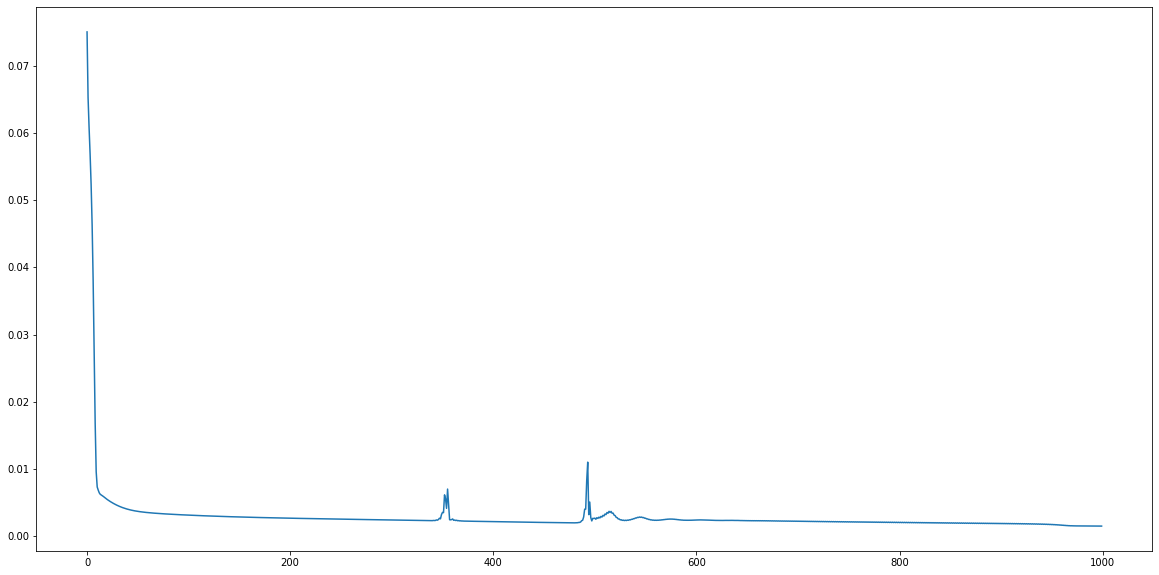

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plt.plot(loss_graph)
plt.show()

In [ ]:
def plotting2(train_loader, test_loader, actual):
  with torch.no_grad():
    train_pred = []
    test_pred = []

    for data in train_loader:
      seq, target = data
      out = model_vanilla2(seq)
      train_pred += out.cpu().numpy().tolist()

    for data in test_loader:
      seq, target = data
      out = model_vanilla2(seq)
      test_pred += out.cpu().numpy().tolist()
      
  total = train_pred + test_pred
  plt.figure(figsize=(20,10))
  plt.plot(np.ones(100)*len(train_pred), np.linspace(0,1,100), '--', linewidth=0.6)
  plt.plot(actual, '--')
  plt.plot(total, 'b', linewidth=0.6)

  plt.legend(['train boundary', 'prediction','actual'])
  plt.show()
  return total

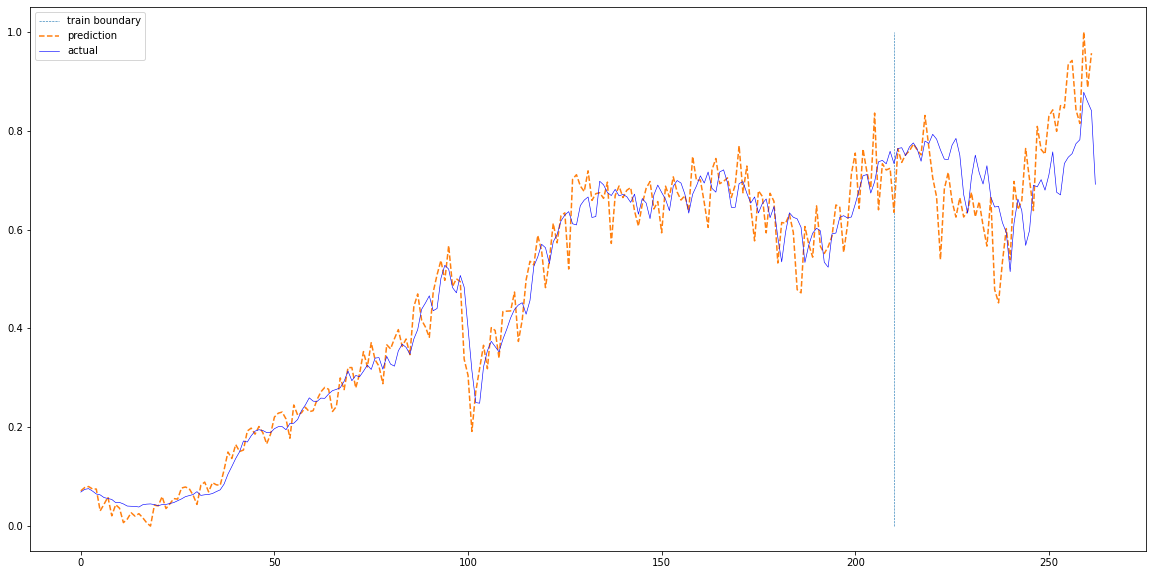

In [ ]:
test_again = plotting2(train_loader2, test_loader2, y2[7:])

In [ ]:
train_predict2 = model_vanilla2(X_seq2)
data_pred_again = train_predict2.cpu()
data_pred_again = data_pred_again.data.numpy()
Y_plot_again = y_seq2.cpu()
Y_plot_again = Y_plot_again.data.numpy()

In [ ]:
data_pred_again2 = np.array(data_pred_again).flatten().tolist()
data_pred_again2 = [0,0,0,0,0,0]+data_pred_again2

In [ ]:
data5 = data4
data4['한국 수출금액'] = data_pred_again2
data4

,기간,한국 수출금액,한국의대중국수출,한국의대미국수출,한국의대베트남수출,한국의대홍콩수출,한국의대일본수출,GDP,Growth_rate
0,2000.01,0.000000,0.000000,0.031762,0.000959,0.019499,0.040227,0.000000,1.000000
1,2000.02,0.000000,0.002687,0.026612,0.001129,0.022854,0.037566,0.000000,1.000000
2,2000.03,0.000000,0.014330,0.063052,0.003556,0.029917,0.058992,0.000000,1.000000
3,2000.04,0.000000,0.009333,0.039955,0.004779,0.026017,0.042735,0.021399,0.773585
4,2000.05,0.000000,0.030341,0.083510,0.004796,0.027938,0.049884,0.021399,0.773585
...,...,...,...,...,...,...,...,...,...
264,2022.01,0.781805,0.860173,1.000000,1.000000,1.000000,1.000000,1.000000,0.276730
265,2022.02,0.877909,0.519801,0.508184,0.613829,0.730498,0.693267,1.000000,0.276730
267,2022.03,0.858677,0.288554,0.275568,0.388568,0.000000,0.314833,1.000000,0.276730
268,2022.04,0.840564,0.089480,0.013551,0.176981,0.142045,0.128257,1.000000,0.276730


In [ ]:
res2 = scaler3.inverse_transform(data4[iv3])
res2 = pd.DataFrame(res2)
y_pred3 = res2[0][264:].values.tolist()
RMSE4 = mean_squared_error(y_real, y_pred3)**0.5
print(RMSE4)

7470789341.306466


In [ ]:
y_pred4 = res2[0][263:].values.tolist()
y_pred4

[51846949808.49588,
 52269053856.72918,
 57339214278.63126,
 56324575918.098366,
 55369014891.98766,
 47508933877.013466]

### 4. Result

RNN모델을 통해 예측한 결과 RMSE 값은 7470789341.306466 가 나온 것을 확인하였다. 보다 나은 성능을 위해 LSTM, GRU 등의 방식을 사용할 수 있을 것이며, 동시에 6개 스텝을 예측하는 모델도 구축할 수 있을 것으로 보인다. 